<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-библиотек-и-глобальных-переменных" data-toc-modified-id="Загрузка-библиотек-и-глобальных-переменных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка библиотек и глобальных переменных</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#LassoRegression" data-toc-modified-id="LassoRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LassoRegression</a></span></li><li><span><a href="#RidgeRegression" data-toc-modified-id="RidgeRegression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RidgeRegression</a></span></li><li><span><a href="#RandomForestRegression" data-toc-modified-id="RandomForestRegression-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RandomForestRegression</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси (учебный)

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

## Подготовка

### Загрузка библиотек и глобальных переменных

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.iolib.table import SimpleTable
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split, cross_val_score

#настройка отображения размеров графиков
rcParams['figure.figsize'] = 20, 10

#настраиваем отображение всех столбцов
pd.set_option('display.max_columns', None)

#добавляем игнорирование ошибок
warnings.filterwarnings('ignore')

### Загрузка данных 

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', 
                       index_col=['datetime'], 
                       parse_dates=['datetime'], 
                       dayfirst=True)
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', 
                       index_col=['datetime'], 
                       parse_dates=['datetime'], 
                       dayfirst=True)

#скопируем датафрейм для дальнейшего сравнения размера после первичной обработки    
data_original = data.copy()

data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
#проверка на монотонность
data.index.is_monotonic

True

In [16]:
data.index.min()

Timestamp('2018-03-01 00:00:00')

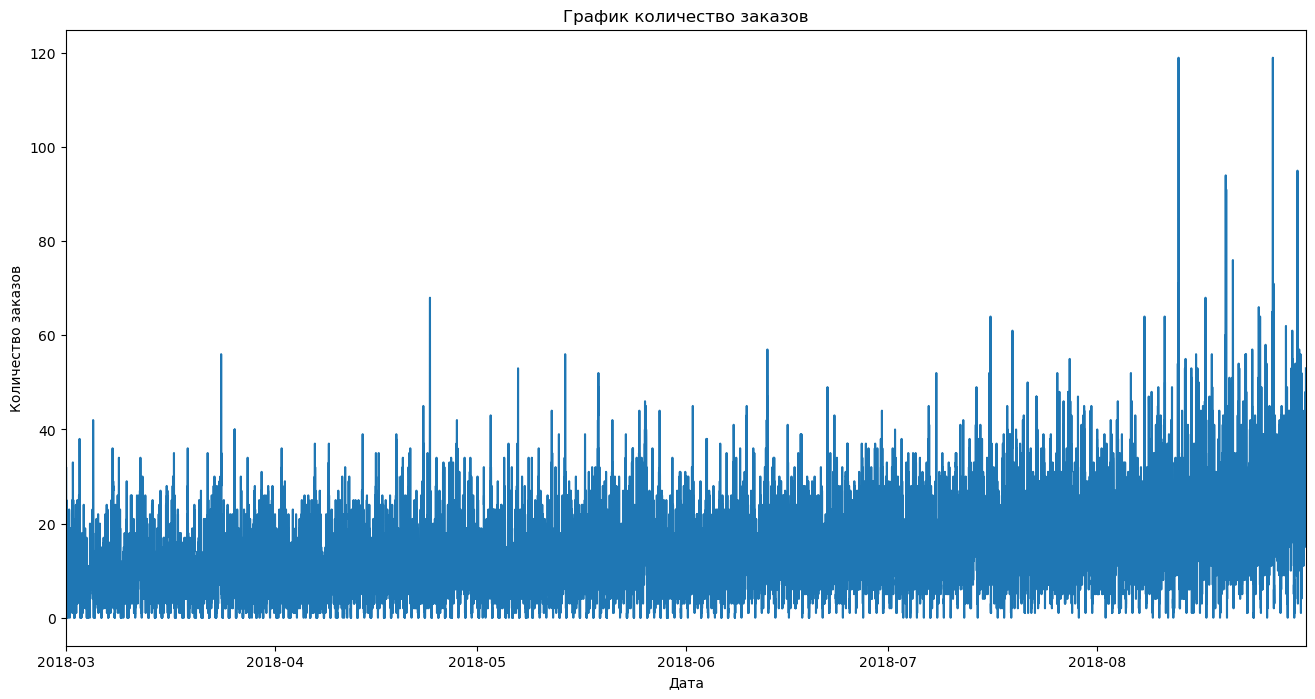

In [18]:
plt.figure(figsize=(16,8))
plt.plot(data)
plt.xlim(data.index.min(), data.index.max())
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('График количество заказов')
plt.show();

In [19]:
#ресеплирование
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


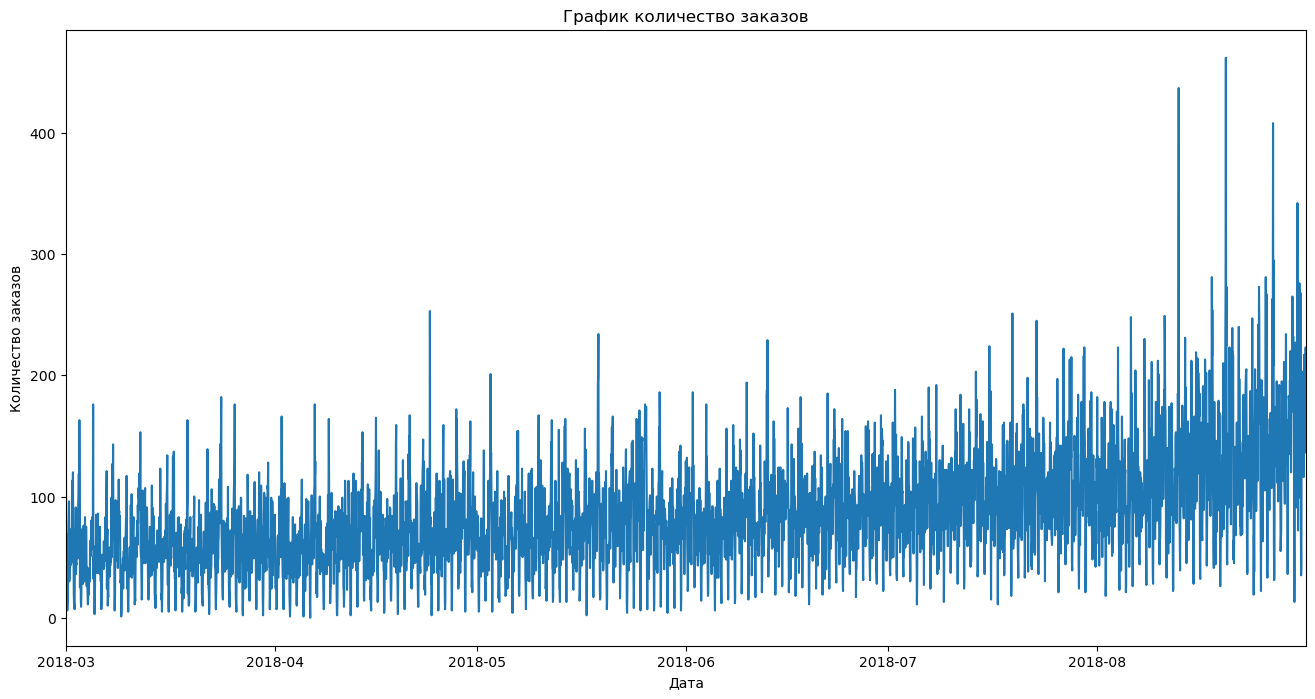

In [20]:
plt.figure(figsize=(16,8))
plt.plot(data)
plt.xlim(data.index.min(), data.index.max())
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('График количество заказов')
plt.show();

**Предварительный вывод:**  
Данные загружены. Выполнено их ресемплирование по одному часу

## Анализ

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


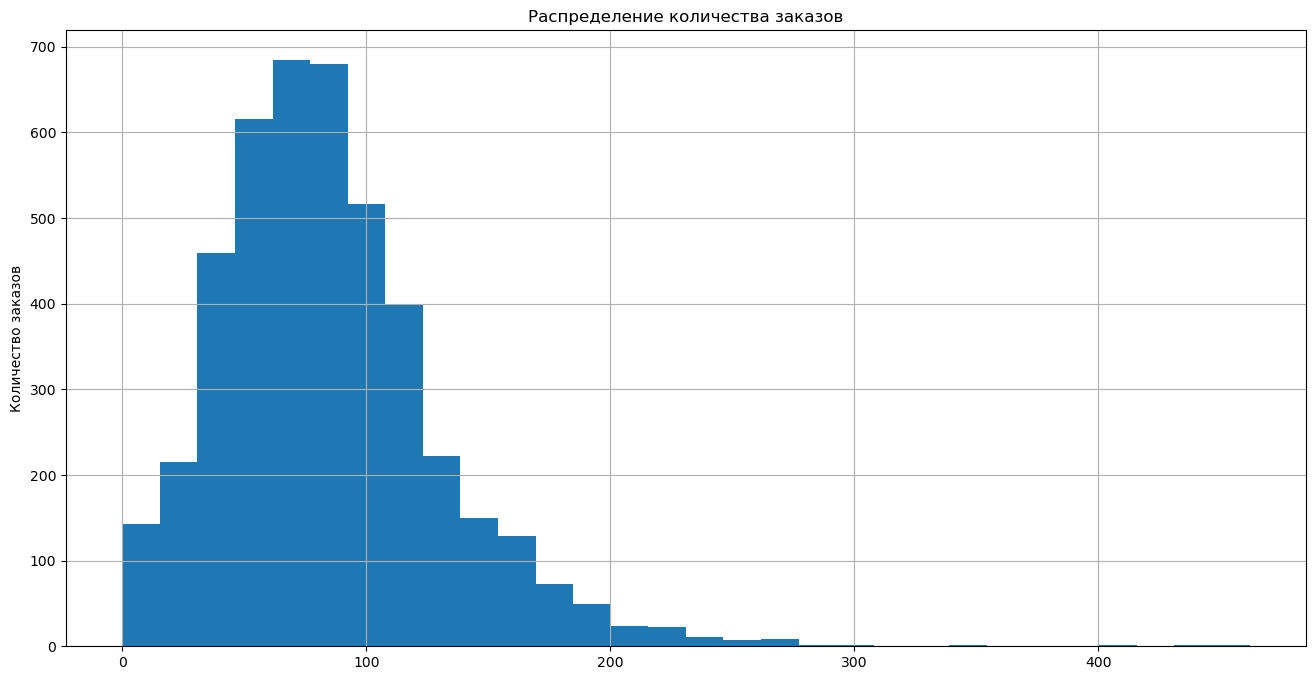

In [29]:
#проанализируем количество заказов
itog = data.describe()
display(itog.T)

plt.figure(figsize=(16,8))
plt.hist(data, bins=30)
#plt.xlim(data.index.min(), data.index.max())
#plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Распределение количества заказов')
plt.grid(True)
plt.show();

In [30]:
#рассчитаем коэффициент вариации
print('V = %f' % (data.std()/data.mean()))

V = 0.533314


Коэффициент вариации небольшой, следовательно ряд имеет относительно небольшой разброс. Из гистограммы видим, что ряд однородный.

Проведем тест Харки — Бера для определения номарльности распределения, чтобы подтвердить предположение об однородности

In [31]:
row = ['JB', 'p-value', 'skew', 'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(data, axis=0)
a = np.vstack([jb_test])
itog = pd.DataFrame(a, row).T
itog

,JB,p-value,skew,kurtosis
0,3644.433552,0.0,1.188552,6.762457


p-value < 0.05 следовательно гипотеза подтверждилась. 

Для проверки проверки стационарности давайте проведем обобщенный тест Дикки-Фуллера на наличие единичных корней

In [32]:
test = sm.tsa.adfuller(data)
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.0689242890279544
p-value:  0.02894005140261296
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


Так как в нашем случае необходим прогноз на следующий час, имеет смысл для построения модели использовать не все данные, а только часть. В первом приближении рассмотрим месяц.

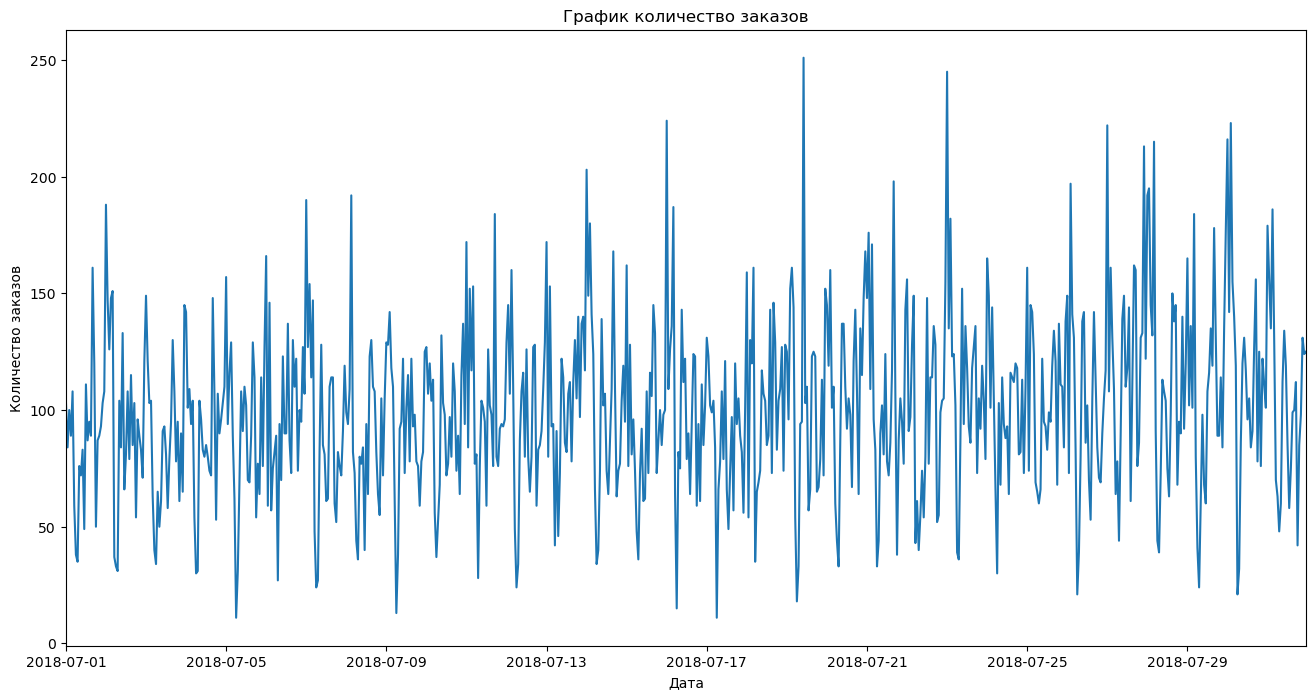

In [34]:
plt.figure(figsize=(16,8))
plt.plot(data['2018-07-01':'2018-07-31'])
plt.xlim(data['2018-07-01':'2018-07-31'].index.min(), data['2018-07-01':'2018-07-31'].index.max())
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('График количество заказов')
plt.show();

Посмотрим на тренд, сезонность.

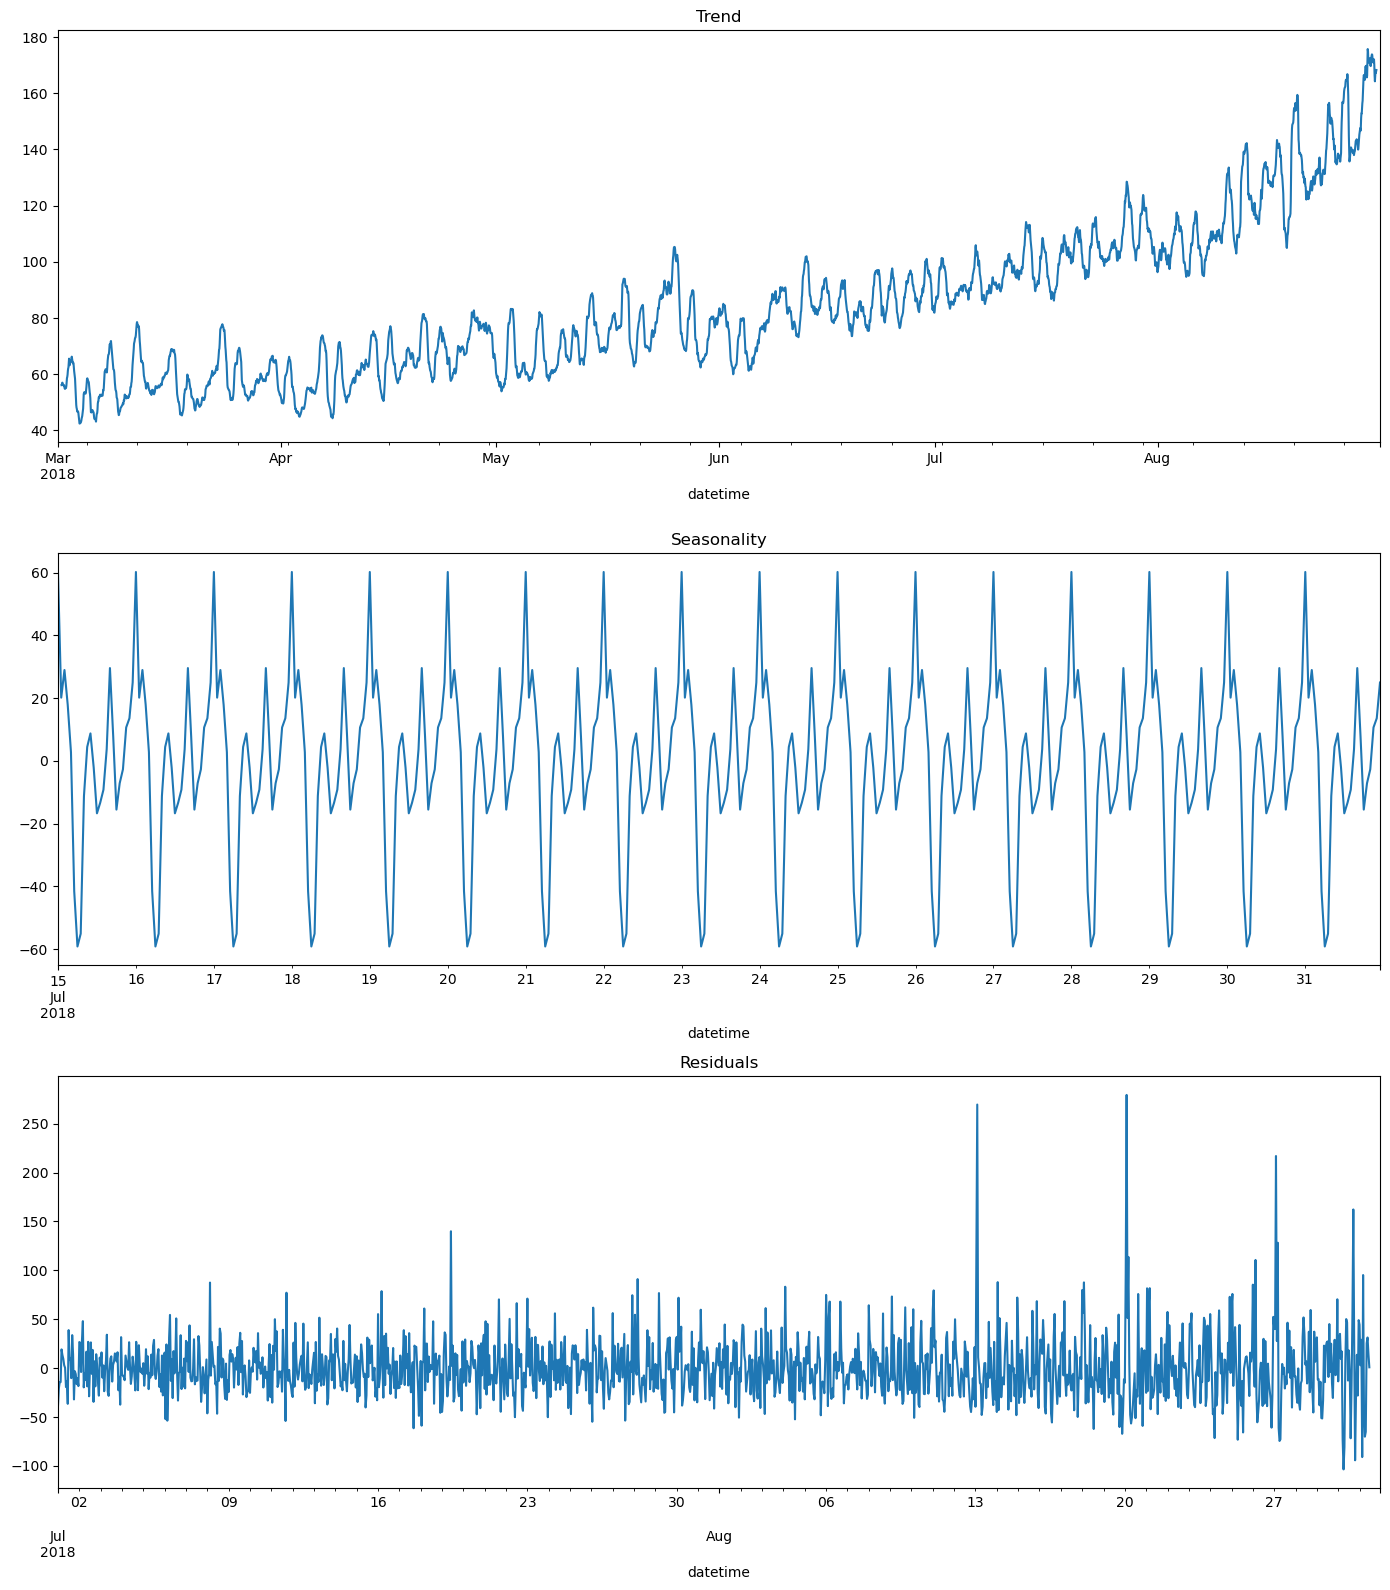

In [35]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(14, 16))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-07-15':'2018-07-31'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid['2018-07-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Рассмотрим тренд приближено

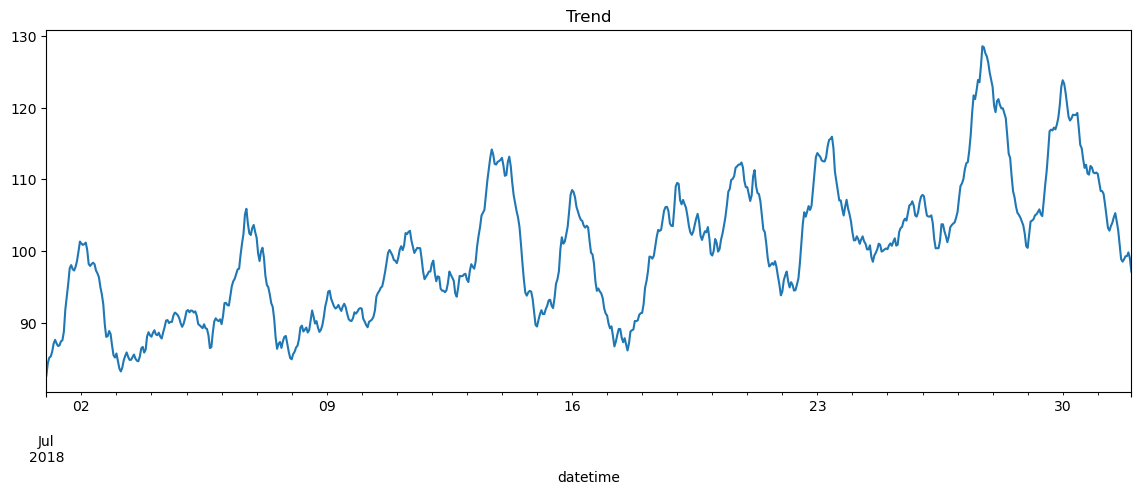

In [36]:
#приближение - один месяц
plt.figure(figsize=(14, 16))
plt.subplot(311)
decomposed.trend['2018-07-01':'2018-07-31'].plot(ax=plt.gca())
plt.title('Trend');

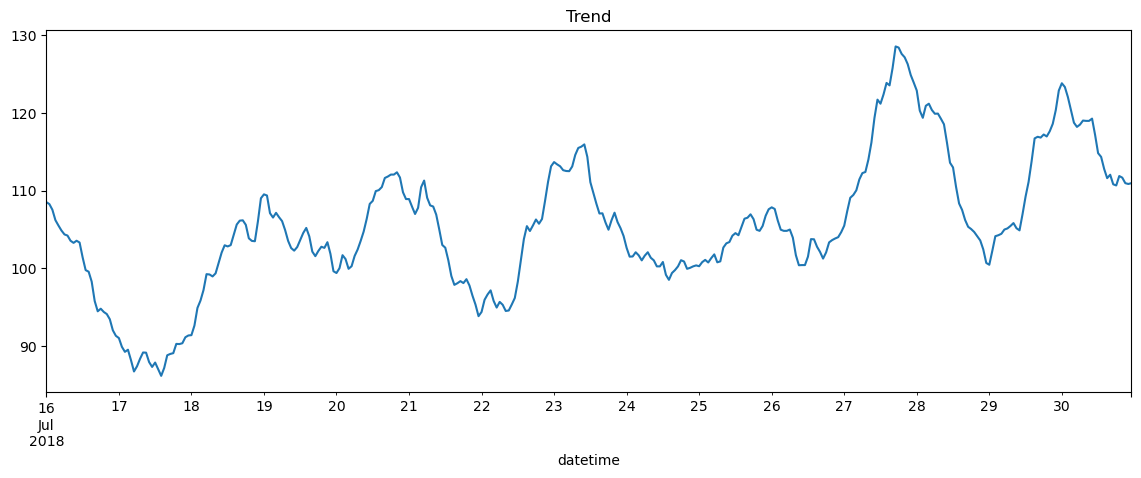

In [37]:
#приближение - две недели
plt.figure(figsize=(14, 16))
plt.subplot(311)
decomposed.trend['2018-07-16':'2018-07-30'].plot(ax=plt.gca())
plt.title('Trend');

**Предварительный вывод:**  
Сезонность аддитивная, тренд возрастающий. Цикл - неделя. Следовательно для дальнейшего исследования и расчета модели достаточно взять данные за последние 10 недель, последнюю неделю для теста (так как по условию задачи нам нужно выделить на тест 10% данных) и девять предыдущих для обучающего набора данных. Остальные более ранние данные для краткосрочного прогнозирования на следующий час не имеют смысла.

## Обучение

In [38]:
def make_features(data, max_lag, rolling_mean_size):
    '''
    Функция принимает на вход:
    data - исходный датафрейм, 
    max_lag - максимальный размер отставания, 
    rolling_mean_size - ширина окна скользящего среднего.
    
    На выход:
    data - датафрейм с новыми признаками
    '''
    #копируем датафрейм
    df = data.copy()
    
    #календарные признаки
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['week'] = df.index.week
    
    
    #отстающие значения
    max_lag = max_lag
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = data['num_orders'].shift(lag) 
    
    #скользящее среднее
    df['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [39]:
#возьмем max_lag равный 24 (количество часов в дне)
data_changed = make_features(data, 24, 7)
data_changed

,num_orders,hour,day,dayofweek,week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,9,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,9,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,9,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,9,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,31,4,35,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,167.428571
2018-08-31 20:00:00,154,20,31,4,35,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.428571
2018-08-31 21:00:00,159,21,31,4,35,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,165.714286


Оставляем последние 10 недель

In [40]:
data_changed = data_changed[data_changed['week'] > 25]

In [41]:
print(data_changed['week'].unique())
data_changed

[26 27 28 29 30 31 32 33 34 35]


,num_orders,hour,day,dayofweek,week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-25 00:00:00,154,0,25,0,26,100.0,124.0,105.0,84.0,96.0,51.0,103.0,154.0,122.0,107.0,42.0,74.0,51.0,60.0,94.0,64.0,22.0,29.0,93.0,164.0,86.0,59.0,64.0,127.0,94.714286
2018-06-25 01:00:00,119,1,25,0,26,154.0,100.0,124.0,105.0,84.0,96.0,51.0,103.0,154.0,122.0,107.0,42.0,74.0,51.0,60.0,94.0,64.0,22.0,29.0,93.0,164.0,86.0,59.0,64.0,102.000000
2018-06-25 02:00:00,82,2,25,0,26,119.0,154.0,100.0,124.0,105.0,84.0,96.0,51.0,103.0,154.0,122.0,107.0,42.0,74.0,51.0,60.0,94.0,64.0,22.0,29.0,93.0,164.0,86.0,59.0,111.714286
2018-06-25 03:00:00,116,3,25,0,26,82.0,119.0,154.0,100.0,124.0,105.0,84.0,96.0,51.0,103.0,154.0,122.0,107.0,42.0,74.0,51.0,60.0,94.0,64.0,22.0,29.0,93.0,164.0,86.0,109.714286
2018-06-25 04:00:00,115,4,25,0,26,116.0,82.0,119.0,154.0,100.0,124.0,105.0,84.0,96.0,51.0,103.0,154.0,122.0,107.0,42.0,74.0,51.0,60.0,94.0,64.0,22.0,29.0,93.0,164.0,114.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,31,4,35,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,167.428571
2018-08-31 20:00:00,154,20,31,4,35,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.428571
2018-08-31 21:00:00,159,21,31,4,35,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,165.714286


Разбиваем данные на обующую и тестовую выборки в соотношении 9:1 (по условию задачи необходимо выделить на тест 10%) 

In [42]:
train, test = train_test_split(data_changed, shuffle=False, test_size=0.1)
train.dropna()
print('Обучающая выборка:')
display(train)
print('Тестовая выборка:')
display(test) 

Обучающая выборка:


,num_orders,hour,day,dayofweek,week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-25 00:00:00,154,0,25,0,26,100.0,124.0,105.0,84.0,96.0,51.0,103.0,154.0,122.0,107.0,42.0,74.0,51.0,60.0,94.0,64.0,22.0,29.0,93.0,164.0,86.0,59.0,64.0,127.0,94.714286
2018-06-25 01:00:00,119,1,25,0,26,154.0,100.0,124.0,105.0,84.0,96.0,51.0,103.0,154.0,122.0,107.0,42.0,74.0,51.0,60.0,94.0,64.0,22.0,29.0,93.0,164.0,86.0,59.0,64.0,102.000000
2018-06-25 02:00:00,82,2,25,0,26,119.0,154.0,100.0,124.0,105.0,84.0,96.0,51.0,103.0,154.0,122.0,107.0,42.0,74.0,51.0,60.0,94.0,64.0,22.0,29.0,93.0,164.0,86.0,59.0,111.714286
2018-06-25 03:00:00,116,3,25,0,26,82.0,119.0,154.0,100.0,124.0,105.0,84.0,96.0,51.0,103.0,154.0,122.0,107.0,42.0,74.0,51.0,60.0,94.0,64.0,22.0,29.0,93.0,164.0,86.0,109.714286
2018-06-25 04:00:00,115,4,25,0,26,116.0,82.0,119.0,154.0,100.0,124.0,105.0,84.0,96.0,51.0,103.0,154.0,122.0,107.0,42.0,74.0,51.0,60.0,94.0,64.0,22.0,29.0,93.0,164.0,114.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-24 23:00:00,173,23,24,4,34,242.0,166.0,179.0,113.0,137.0,170.0,188.0,117.0,88.0,144.0,118.0,151.0,205.0,170.0,95.0,38.0,68.0,19.0,93.0,103.0,154.0,174.0,247.0,170.0,170.714286
2018-08-25 00:00:00,273,0,25,5,34,173.0,242.0,166.0,179.0,113.0,137.0,170.0,188.0,117.0,88.0,144.0,118.0,151.0,205.0,170.0,95.0,38.0,68.0,19.0,93.0,103.0,154.0,174.0,247.0,168.571429
2018-08-25 01:00:00,246,1,25,5,34,273.0,173.0,242.0,166.0,179.0,113.0,137.0,170.0,188.0,117.0,88.0,144.0,118.0,151.0,205.0,170.0,95.0,38.0,68.0,19.0,93.0,103.0,154.0,174.0,183.285714


Тестовая выборка:


,num_orders,hour,day,dayofweek,week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-08-25 04:00:00,196,4,25,5,34,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0,137.0,170.0,188.0,117.0,88.0,144.0,118.0,151.0,205.0,170.0,95.0,38.0,68.0,19.0,93.0,206.714286
2018-08-25 05:00:00,118,5,25,5,34,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0,137.0,170.0,188.0,117.0,88.0,144.0,118.0,151.0,205.0,170.0,95.0,38.0,68.0,19.0,211.000000
2018-08-25 06:00:00,74,6,25,5,34,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0,137.0,170.0,188.0,117.0,88.0,144.0,118.0,151.0,205.0,170.0,95.0,38.0,68.0,193.285714
2018-08-25 07:00:00,22,7,25,5,34,74.0,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0,137.0,170.0,188.0,117.0,88.0,144.0,118.0,151.0,205.0,170.0,95.0,38.0,179.142857
2018-08-25 08:00:00,108,8,25,5,34,22.0,74.0,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0,137.0,170.0,188.0,117.0,88.0,144.0,118.0,151.0,205.0,170.0,95.0,143.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,31,4,35,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,167.428571
2018-08-31 20:00:00,154,20,31,4,35,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.428571
2018-08-31 21:00:00,159,21,31,4,35,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,165.714286


### LinearRegression

In [43]:
x_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

x_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [44]:
model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(model, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

In [45]:
linear_rmse = - scores.mean()
linear_rmse

34.20416340672456

In [46]:
models_compares = {
    'LinearRegression':{
        'rmse': round(linear_rmse, 3),
    }
}
models_statistics = pd.DataFrame(models_compares).T
models_statistics 

,rmse
LinearRegression,34.204


### LassoRegression

In [47]:
best_rmse = 10000
best_alpha = 0
alpha = [0.1, 0.5, 0.8]
for a in alpha:
    model = Lasso(alpha=a)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(model, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()
    if scores < best_rmse:
        best_rmse = - scores
        best_alpha = a

print(
    f'alpha: {best_alpha}\n'
    f'RMSE: {best_rmse}'
)   

alpha: 0.8
RMSE: 34.185020224637704


In [48]:
lasso_rmse = best_rmse

In [49]:
models_compares['Lasso'] ={
        'rmse': round(lasso_rmse, 3),
    }
models_statistics = pd.DataFrame(models_compares).T
models_statistics 

,rmse
LinearRegression,34.204
Lasso,34.185


### RidgeRegression

In [50]:
best_rmse = 10000
best_alpha = 0
alpha = [0.1, 0.5, 0,8, 1.0]
for a in alpha:
    model = Ridge(alpha=a)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(model, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()
    
    if scores < best_rmse:
        best_rmse = - scores
        best_alpha = a

print(
    f'alpha: {best_alpha}\n'
    f'RMSE: {best_rmse}'
)   

alpha: 1.0
RMSE: 34.18089058643238


In [51]:
ridge_rmse = best_rmse

In [52]:
models_compares['Ridge'] ={
        'rmse': round(ridge_rmse, 3),
    }
models_statistics = pd.DataFrame(models_compares).T
models_statistics 

,rmse
LinearRegression,34.204
Lasso,34.185
Ridge,34.181


### RandomForestRegression

In [53]:
best_rmse = 10000
best_depth = 0
best_estim = 0
for estim in range(3, 16, 3):
    for depth in range(8, 14, 2):
        model = RandomForestRegressor(random_state=12345, n_estimators=estim, max_depth=depth)
        tscv = TimeSeriesSplit(n_splits=5)
        scores = cross_val_score(model, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()
    
        if scores < best_rmse:
            best_rmse = - scores
            best_depth = depth
            best_estim = estim
print(
    f'Количество деревьев: {best_estim}\n'
    f'Глубина: {best_depth}\n'
    f'RMSE: {best_rmse}'
)

Количество деревьев: 15
Глубина: 12
RMSE: 30.901739417879895


In [54]:
rf_rmse = best_rmse

In [55]:
models_compares['RandomForestRegressor'] ={
        'rmse': round(rf_rmse, 3),
    }
models_statistics = pd.DataFrame(models_compares).T
models_statistics 

,rmse
LinearRegression,34.204
Lasso,34.185
Ridge,34.181
RandomForestRegressor,30.902


**Предварительный вывод:**  
- Выборки разделены. 
- обучено 4 модели
- лучшая модель RandomForestRegressor

## Тестирование

Найдем RMSE для тестовой выборки.

In [56]:
final_model = RandomForestRegressor(random_state=12345, n_estimators=best_estim, max_depth=best_depth)
final_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=12, n_estimators=15, random_state=12345)

In [57]:
prediction = final_model.predict(x_test)
rf_rmse_test = mean_squared_error(y_test, prediction) ** 0.5
rf_rmse_test

45.96831441106699

In [58]:
models_compares['RandomForestRegressor (test)'] ={
        'rmse': round(rf_rmse_test, 3),
    }
models_statistics = pd.DataFrame(models_compares).T
models_statistics 

,rmse
LinearRegression,34.204
Lasso,34.185
Ridge,34.181
RandomForestRegressor,30.902
RandomForestRegressor (test),45.968


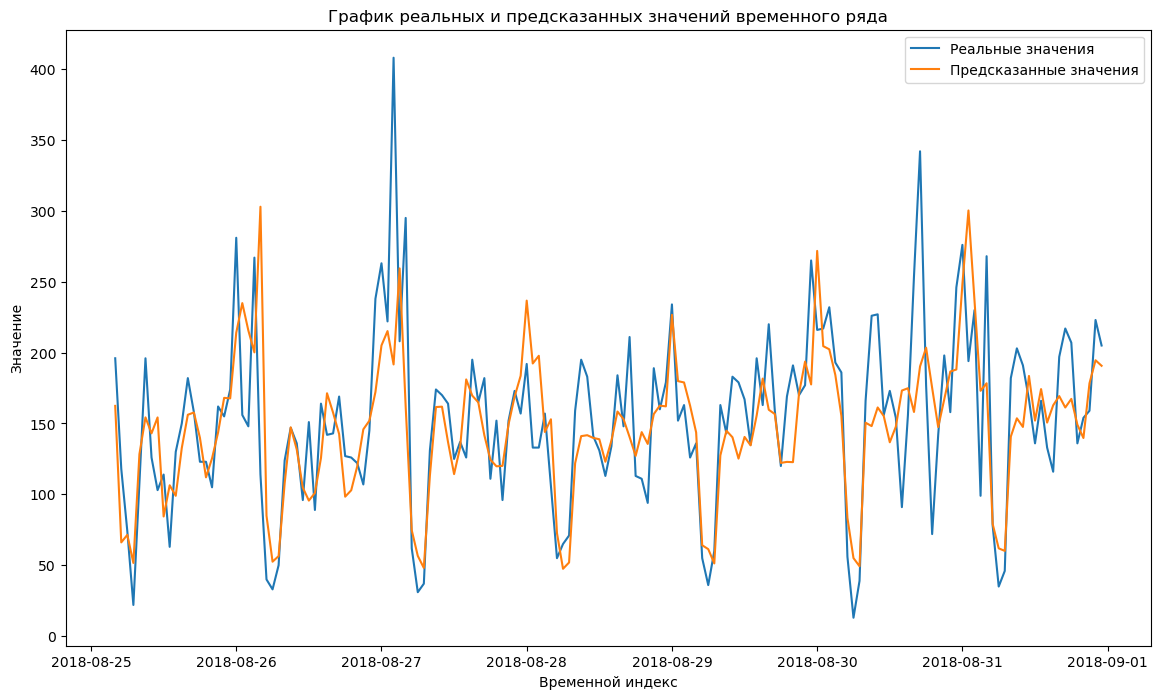

In [59]:
plt.figure(figsize=(14, 8))
plt.plot(y_test.index, y_test, label='Реальные значения')
plt.plot(y_test.index, prediction, label='Предсказанные значения')
plt.xlabel('Временной индекс')
plt.ylabel('Значение')
plt.title('График реальных и предсказанных значений временного ряда')
plt.legend()
plt.show()

**Общий вывод:**  
- Проведен анализ данных
- Выявлена недельная и дневная сезонность.
- Тренд в данных восходящий.
- Проведено сравнительное исследование 4х регрессионных моделей
- лучшая модель RandomForestRegressor
- RMSE тестовой выборки 45.968 (условие получить метрику менее 48 выполнено)